the new stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
from scipy.integrate import cumulative_simpson as cumsimp


In [2]:
x = np.linspace(0, 10, 100)
rng = np.random.default_rng() # new way of calling random generators apparently

# Kernels

## Square Exponential / RBF

In [3]:
def KSE(x,sigma=1,l=1):
    """The square exponential covariance function. 
    Only works for 1D input. And with itself."""
    
    n = len(x)
    K = np.array([[sigma**2 * np.exp(-(x[i] - x[j])**2 / (2 * l**2)) for j in range(n)] for i in range(n)])

    return K


In [4]:
K = KSE(x)

<Axes: >

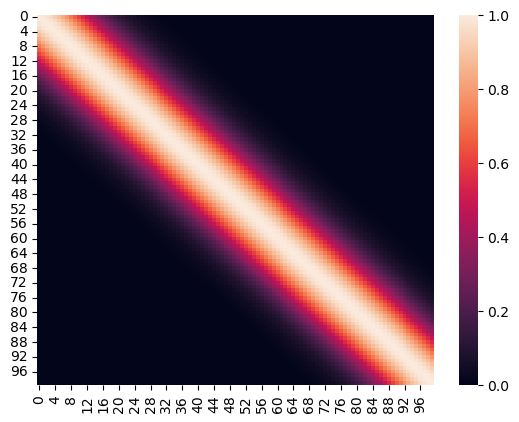

In [5]:
sns.heatmap(K)

In [6]:
rng = np.random.default_rng() # new way of calling random generators apparently

y = rng.multivariate_normal(np.zeros(len(x)), cov=K) # mean of zero, SE kernel

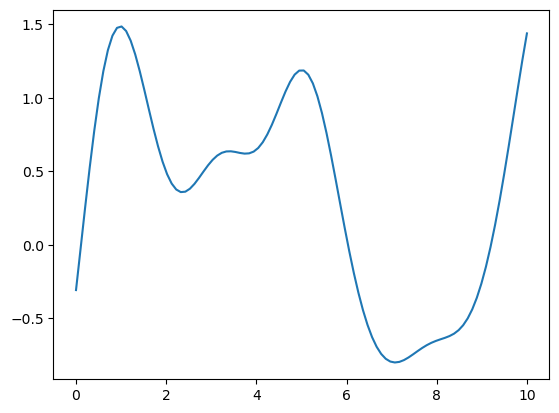

In [7]:
plt.plot(x, y)

## Second Kernel

# Crust EOS

In [8]:
crust_eos= np.loadtxt('EOS/crust/crust_eos.dat')

In [9]:
n_crust, e_crust, p_crust, cs2_crust = crust_eos.T # unpacking the data into separate arrays

In [10]:
mu_ini = (e_crust[-1] + p_crust[-1]) / n_crust[-1]

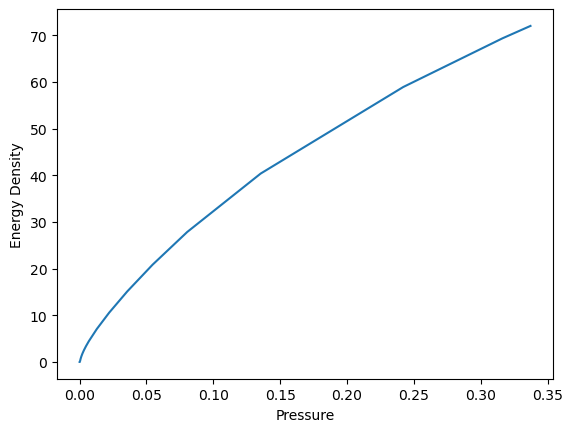

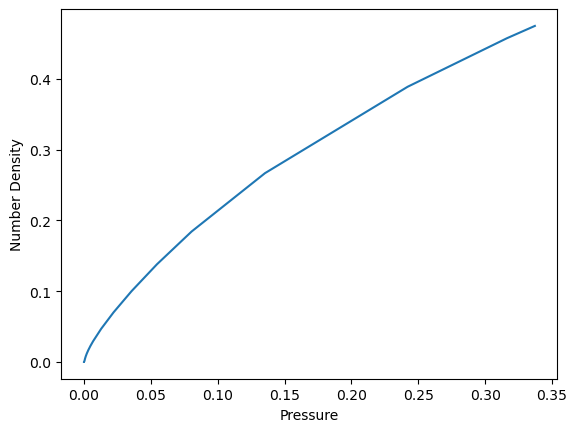

In [11]:
plt.plot(p_crust, e_crust, label='Crust EOS')
plt.xlabel('Pressure')
plt.ylabel('Energy Density')
plt.show()

plt.plot(p_crust, n_crust/0.16, label='Crust EOS')
plt.xlabel('Pressure')
plt.ylabel('Number Density')
plt.show() 

# Mean EOS

In [12]:
mean_eos = np.loadtxt('EOS/mean/36022_microscopic.dat')

n_mean, e_mean, p_mean, cs2_mean = mean_eos.T

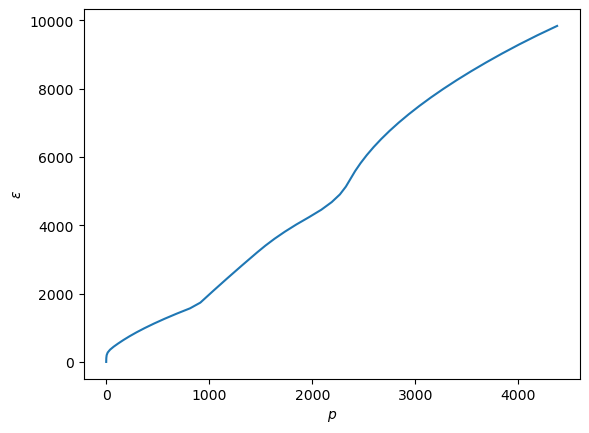

In [13]:
plt.plot(p_mean,e_mean)
plt.xlabel(r'$p$')
plt.ylabel(r'$\epsilon$')
plt.show()

In [14]:
phi_mean = np.log(1/cs2_mean - 1)

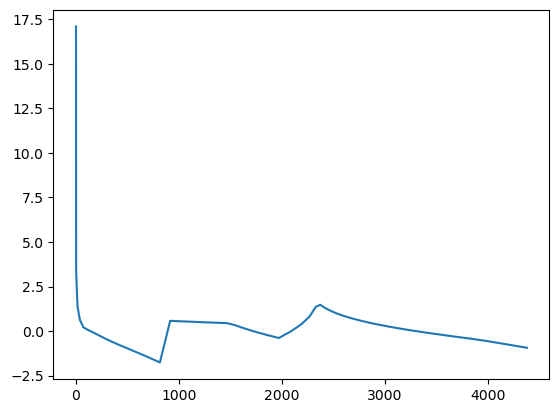

In [15]:
plt.plot(p_mean,phi_mean)

# $\phi$

$$\phi = \log (c^2 \frac{\mathrm{d} \epsilon}{\mathrm{d} p} -1)$$

$$c^2 \frac{\mathrm{d} \epsilon}{\mathrm{d} p} -1 > 0$$
$$ c^2 \frac{\mathrm{d} \epsilon}{\mathrm{d} p} > 1 $$
c = 1 then
$$\frac{\mathrm{d} \epsilon}{\mathrm{d} p} > 1 $$
Gradient is always positive

The other physics from phi is that causality and thermodynamic stability and positivity of total energy in taken into fact

In [16]:
# Define symbols
phi, c, p = sp.symbols('phi c p')
epsilon = sp.Function('epsilon')(p)

# Define the equation
equation = sp.log(c**2 * epsilon.diff(p) - 1) - phi

# Solve for d(epsilon)/dp
d_epsilon_dp = sp.solve(equation, epsilon.diff(p))[0]
d_epsilon_dp

(exp(phi) + 1)/c**2

In [17]:
p = np.logspace(np.log10(p_crust[-1]), np.log10(2000) , 100) # logspace from final value of crust pressure to 2000, note logspace uses base10
log_p = np.log(p)

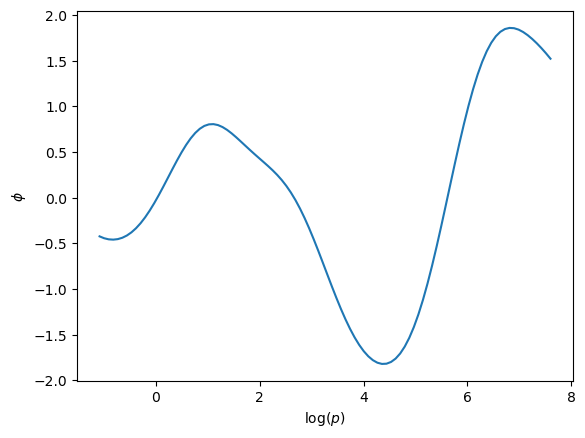

<function matplotlib.pyplot.show(close=None, block=None)>

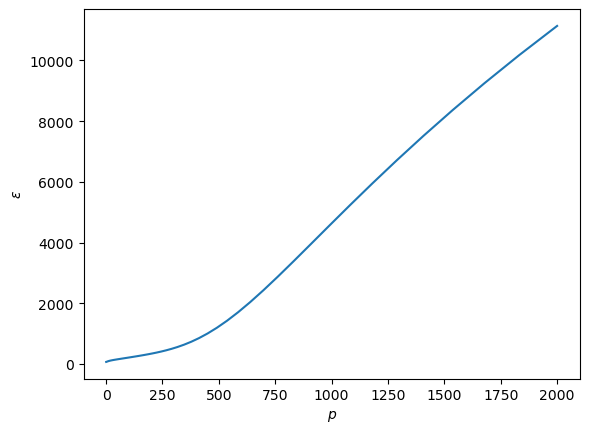

In [18]:
covP = KSE(log_p)
phi = rng.multivariate_normal(np.zeros(len(log_p)), cov=covP)

plt.plot(log_p, phi)
plt.xlabel(r'$\log(p)$')
plt.ylabel(r'$\phi$')
plt.show()

d_epsilon_dp = (np.exp(phi) + 1)

# Numerically integrate to find epsilon
from scipy.integrate import cumulative_simpson as cumsimp
epsi = cumsimp(y=d_epsilon_dp, x=p, initial=e_crust[-1])

plt.plot(p, epsi)
plt.xlabel(r'$p$')
plt.ylabel(r'$\epsilon$')
plt.show

In [19]:
def random_GP_realisation(x, mean=None, kernel=None, labels=None):
    """Generate random GPs from a mean and kernel function,
    or from an array of x values, then default is a zero mean and SE kernel.
    labels: array containing ['xlabel','ylabel']
    also uses a crust EOS as initial value for the integral
    """
    if mean is None:
        mean = np.zeros(len(x))
    if kernel is None:
        kernel = KSE(x)
        
    rng = np.random.default_rng() # new way of calling random generators apparently
    y = rng.multivariate_normal(mean, cov=kernel) # mean of zero, SE kernel

    plt.plot(x, y)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1]) #TODO make latex work here
    plt.show()
    
    return y

def plot_random_phiGP_to_epi(log_p, mean=None, kernel=None, c=1):
    """Random realisations of GP in phi log p space 
    and covertion to epsilon and p space"""

    if mean is None:
        mean = np.zeros(len(log_p))
    if kernel is None:
        kernel = KSE(log_p)

    phi = random_GP_realisation(log_p, labels=[r'\log P',r'\phi'])

    dp = np.gradient(p)
    d_epsilon_dp = (np.exp(phi) + 1) / c**2
    # Numerically integrate to find epsilon
    epsi = cumsimp(y=d_epsilon_dp, x=p, initial=e_crust[-1])

    plt.plot(p, epsi)
    plt.xlabel(r'$p$')
    plt.ylabel(r'$\epsilon$')
    plt.show

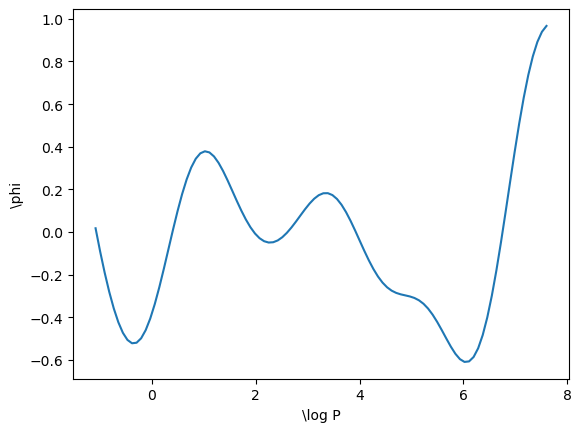

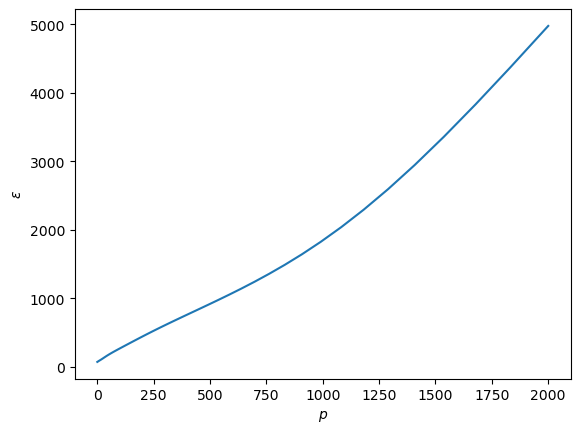

In [20]:
plot_random_phiGP_to_epi(log_p)

$$\ln \frac{\mu(\epsilon)}{\mu(\epsilon_0)} = \int^{\epsilon}_{\epsilon_0}\mathrm{d} \epsilon' \frac{c_s^2(\epsilon')}{\epsilon' + p}$$

Let the integral be I

$$\ln \frac{\mu(\epsilon)}{\mu(\epsilon_0)} = I$$
$$\frac{\mu(\epsilon)}{\mu(\epsilon_0)} = e^I$$
$$\mu_{\epsilon} = e^I \mu_0$$


$\mu(\epsilon_0)$ is found using crust models, look this up or ask Hauke for more details on this

The integral arry has large values, so exponentiating them leads to overflow and infinities. 
$$\ln \frac{\mu(\epsilon)}{\mu(\epsilon_0)} = I$$
$$\ln\mu(\epsilon) - \ln\mu_{\epsilon_0} = I$$
$$\ln\mu(\epsilon) = I + \ln\mu_{\epsilon_0}$$

For now $\mu(\epsilon)=m_n$

$$m_n= 1.67\times 10^{-27}\text{kg} = 939.545 \text{MeV/c}^2$$

And number density from the above:
$$n=\frac{\epsilon+p}{\mu}$$
and in log:
$$\ln n = \ln (\frac{\epsilon+p}{\mu}) = \ln (\epsilon+p)-\ln\mu$$

For this we are assuming that only neutrons exist, see eq 4 in the NS EOS review


In [21]:
def get_sound_speed_squared(phi = None ,epsilon=None, pressure=None, c=1):
    """ From eq 35 of the NS EOS review
    c_s^2 = d(epsilon)/dp * c

    but also considering that we have a GP for phi: 
    1 + exp(phi) = d(epsilon)/dp + c^2,
    so: c_s^2 = 1/(1+exp(phi))
    """
    if epsilon is None:
        c_s2 = 1/(1 + np.exp(phi))
    
    else:
        c_s2 = np.gradient(pressure, epsilon) * c

    if epsilon is None and phi is None:
        raise ValueError('You need to provide either epsilon or phi')

    return c_s2

In [22]:
def get_chemical_potential(epsilon, pressure, c_s2, mu_init=mu_ini):

    """Returns array filled with mu(epsilon)
    Assumes mu_0 is m_n for now"""

    # compute the integrand
    integrand = c_s2 / (epsilon + pressure)

    # numerically integrate using cumulative trapezoidal rule
    integral = cumsimp(y=integrand[:], x=epsilon[:], initial=np.log(mu_init))  # Integral array, mu_int inserted as result[0] and added to rest of result

    # log of chemical potential at each epsilon
    ln_mu = integral

    return ln_mu

In [23]:
cs2 = get_sound_speed_squared(phi=phi)

ln_mu = get_chemical_potential(epsi,p,cs2)

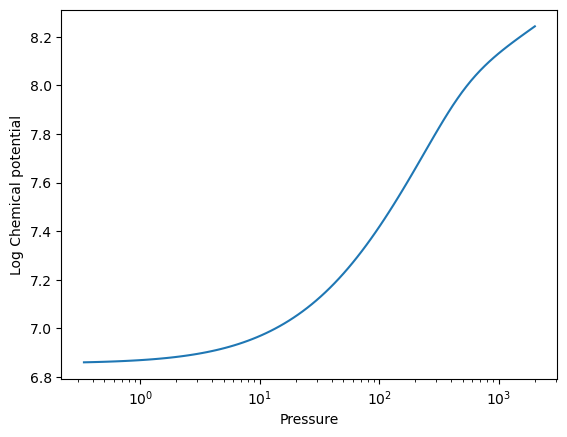

In [24]:
plt.plot(p,ln_mu)
plt.xscale('log')
plt.xlabel('Pressure')
plt.ylabel('Log Chemical potential')
plt.show()

$$n = \frac{\epsilon+P}{\mu}$$
$$\ln n = \ln (\epsilon+P)-\ln\mu$$


In [25]:
def get_number_density(epsilon,pressure,ln_mu):
    
    """From energy, pressure and chemical potential get the number density"""

    mu = np.exp(ln_mu)

    n = (epsilon+pressure)/mu

    return n

In [26]:
n = get_number_density(epsi,p,ln_mu)

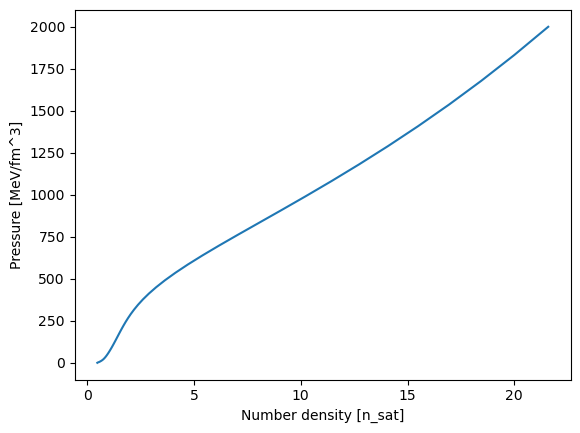

In [27]:
plt.plot(n/0.16,p)
plt.ylabel('Pressure [MeV/fm^3]')
plt.xlabel('Number density [n_sat]')
plt.show()

In [28]:
def run_GP(log_p, mean, kernel, c=1):
    """
    input log_p, mean, kernel, (TODO hyperparameters)
    returns number density, epsilon, sound speed squared, log chemical potential
    """

    covP = kernel(log_p)
    phi = rng.multivariate_normal(mean, cov=covP)

    # get epsilon
    d_epsilon_dp = (np.exp(phi) + 1)
    epsilon = cumsimp(y=d_epsilon_dp, x=p, initial=e_crust[-1])

    # get sound speed squared
    cs2 = get_sound_speed_squared(phi=phi)

    # get chemical potential
    ln_mu = get_chemical_potential(epsilon,p,cs2)

    # get number density
    n = get_number_density(epsilon,p,ln_mu)

    return n, epsilon, cs2, ln_mu

# Generate Multiple

In [29]:
def epsi_from_phi(phi_mean, covarian_matrix, init_e=e_crust[-1]):

    phi = rng.multivariate_normal(phi_mean, cov=covarian_matrix) # GP for phi using mean of phi from an EOS
    d_epsilon_dp_mean = (np.exp(phi) + 1)
    epsi = cumsimp(y=d_epsilon_dp_mean, x=p_mean, initial=init_e)

    return epsi

here, there is a problem. phi means are calculated at pressure positions present in the EOS.

but p_new is a logspace from lowest to highest pressure values of the EOS. the p_new does not match with the pressures from the EOS apart from these two values.

so the phi means are happening at wrong positions. 

maybe a fix would be interpolate phi means for the EOS (using a GP??)


In [30]:
cov_LogPmean = KSE(np.log(p_mean))

epsilons = epsi_from_phi(phi_mean, cov_LogPmean)

epsilons = np.array([epsi_from_phi(phi_mean, cov_LogPmean) for _ in range(5000)])

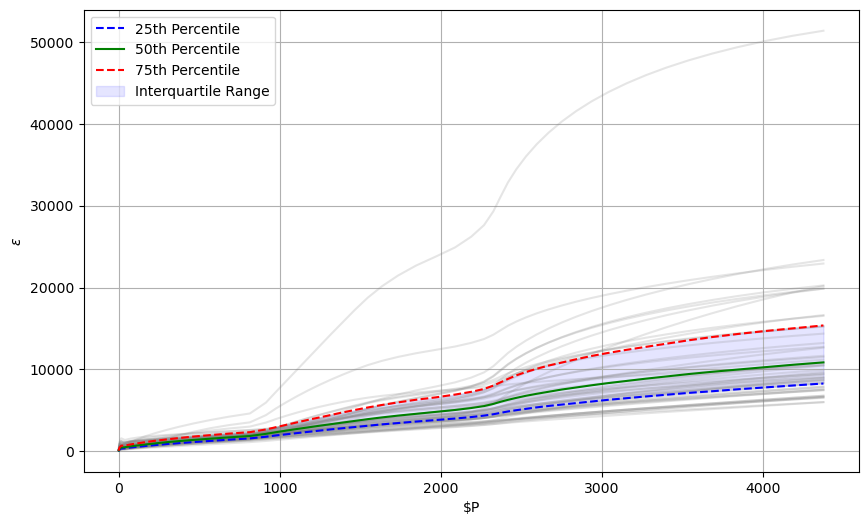

In [31]:
# quantiles
q25 = np.percentile(epsilons, 25, axis=0)  
q50 = np.percentile(epsilons, 50, axis=0)  
q75 = np.percentile(epsilons, 75, axis=0)

plt.figure(figsize=(10, 6))
for epsilon in epsilons[:50]:
    plt.plot(p_mean, epsilon, color='gray', alpha=0.2)

plt.plot(p_mean, q25, label="25th Percentile", color='blue', linestyle='--')
plt.plot(p_mean, q50, label="50th Percentile", color='green', linestyle='-')
plt.plot(p_mean, q75, label="75th Percentile", color='red', linestyle='--')

plt.fill_between(p_mean, q25, q75, color='blue', alpha=0.1, label="Interquartile Range")
plt.xlabel(r"$P")
plt.ylabel(r'$\epsilon$')
plt.legend()
plt.grid(True)

plt.show()